Epoch 1/30
82/82 [==============================] - 516s 6s/step - loss: 1.7431 - accuracy: 0.2195 - val_loss: 1.7591 - val_accuracy: 0.1776
Epoch 2/30
82/82 [==============================] - 683s 8s/step - loss: 1.6434 - accuracy: 0.2165 - val_loss: 1.8374 - val_accuracy: 0.2105
Epoch 3/30
82/82 [==============================] - 439s 5s/step - loss: 1.6376 - accuracy: 0.2104 - val_loss: 1.6066 - val_accuracy: 0.1908
Epoch 4/30
82/82 [==============================] - 321s 4s/step - loss: 1.6518 - accuracy: 0.2302 - val_loss: 1.6768 - val_accuracy: 0.3487
Epoch 5/30
82/82 [==============================] - 375s 5s/step - loss: 1.6010 - accuracy: 0.2470 - val_loss: 1.6535 - val_accuracy: 0.2237
Epoch 6/30
82/82 [==============================] - 323s 4s/step - loss: 1.5602 - accuracy: 0.2973 - val_loss: 1.5811 - val_accuracy: 0.2697
Epoch 7/30
82/82 [==============================] - 320s 4s/step - loss: 1.5035 - accuracy: 0.3399 - val_loss: 1.3749 - val_accuracy: 0.3750
Epoch 8/30
82

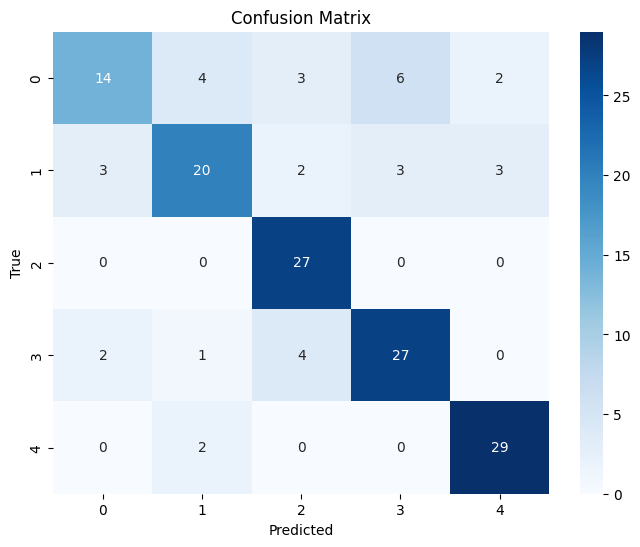

In [2]:
import tensorflow as tf

from tensorflow import keras

from keras import layers

import numpy as np

import cv2

import os

import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Configuration

NUM_CLASSES = 5

FRAMES_PER_VIDEO = 16

IMG_SIZE = 128

PATCH_SIZE = 16  

EMBED_DIM = 64  

NUM_HEADS = 4  

DEPTH = 4  

BATCH_SIZE = 8

EPOCHS = 30

# Function to extract frames from videos

def extract_frames(video_path, num_frames=FRAMES_PER_VIDEO):

    cap = cv2.VideoCapture(video_path)

    frames = []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    for i in frame_indices:

        cap.set(cv2.CAP_PROP_POS_FRAMES, i)

        ret, frame = cap.read()

        if ret:

            frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))

            frames.append(frame)

        else:

            break

    cap.release()

    frames = np.array(frames)

    # Padding if extracted frames are fewer than expected

    if len(frames) < num_frames:

        pad = np.zeros((num_frames - len(frames), IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

        frames = np.vstack((frames, pad))

    return frames/255.0

# Load dataset with proper directory structure

def load_video_paths(data_dir):

    classes = sorted(os.listdir(data_dir))

    video_paths, labels = [], []

    for class_index, class_name in enumerate(classes):

        class_path = os.path.join(data_dir, class_name)

        video_files = glob.glob(os.path.join(class_path, "*.mp4"))  # Load only MP4 files

        for video_file in video_files:

            video_paths.append(video_file)

            labels.append(class_index)

    return video_paths, keras.utils.to_categorical(labels, NUM_CLASSES)

# Load training and testing datasets separately

train_videos, train_labels = load_video_paths("E:\FINAL\TRAIN")

test_videos, test_labels = load_video_paths("E:\FINAL\TEST")

# Data Generator

class VideoDataGenerator(keras.utils.Sequence):

    def __init__(self, video_list, labels, batch_size, shuffle=True):

        self.video_list = video_list

        self.labels = labels

        self.batch_size = batch_size

        self.shuffle = shuffle

        self.indexes = np.arange(len(self.video_list))

        self.on_epoch_end()

    def __len__(self):

        return int(np.floor(len(self.video_list) / self.batch_size))

    def __getitem__(self, index):

        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        video_batch = [self.video_list[k] for k in indexes]

        label_batch = [self.labels[k] for k in indexes]

        x_batch = np.array([extract_frames(video) for video in video_batch]) / 255.0

        y_batch = np.array(label_batch)

        return x_batch, y_batch

    def on_epoch_end(self):

        if self.shuffle:

            np.random.shuffle(self.indexes)

# Creating training and testing data generators

train_generator = VideoDataGenerator(train_videos, train_labels, BATCH_SIZE)

test_generator = VideoDataGenerator(test_videos, test_labels, BATCH_SIZE)

# Tubelet Embedding 

def TubeletEmbedding():

    return keras.Sequential([

        layers.Conv3D(EMBED_DIM, kernel_size=(4, PATCH_SIZE, PATCH_SIZE), strides=(4, PATCH_SIZE, PATCH_SIZE)),

        layers.Reshape((-1, EMBED_DIM))

    ])

# Positional Encoding

def PositionalEncoding(sequence_length, embed_dim):

    positions = np.arange(sequence_length)[:, np.newaxis]

    dimensions = np.arange(embed_dim)[np.newaxis, :]

    angle_rates = 1 / np.power(10000, (2 * (dimensions // 2)) / np.float32(embed_dim))

    pos_encoding = positions * angle_rates

    pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])

    pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])

    return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)

# Factorized Self-Attention

def FactorizedTransformerBlock():

    def apply(inputs):

        x = layers.LayerNormalization()(inputs)

        x = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBED_DIM)(x, x)

        x = layers.Add()([x, inputs])

        x = layers.LayerNormalization()(x)

        x = layers.Dense(EMBED_DIM * 2, activation='gelu')(x)

        x = layers.Dense(EMBED_DIM)(x)

        x = layers.Add()([x, inputs])

        return x

    return apply

# ViViT Model

def build_vivit_model():

    inputs = layers.Input(shape=(FRAMES_PER_VIDEO, IMG_SIZE, IMG_SIZE, 3))

    x = TubeletEmbedding()(inputs)

    x += PositionalEncoding(x.shape[1], EMBED_DIM)

    for _ in range(DEPTH):

        x = FactorizedTransformerBlock()(x)

    x = layers.GlobalAveragePooling1D()(x)

    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    return keras.Model(inputs, outputs)

# Compile and Train the Model

model = build_vivit_model()

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model

history = model.fit(train_generator, validation_data=test_generator, epochs=EPOCHS)


test_loss, test_acc = model.evaluate(test_generator)

print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Generate predictions for the test set

def get_predictions(generator):

    y_true = []

    y_pred = []

    for batch_x, batch_y in generator:

        # Predict batch

        batch_pred = model.predict(batch_x)

        # Get the predicted class labels

        pred_labels = np.argmax(batch_pred, axis=1)

        true_labels = np.argmax(batch_y, axis=1)

        # Append the results to the lists

        y_true.extend(true_labels)

        y_pred.extend(pred_labels)

    return np.array(y_true), np.array(y_pred)

# Get true and predicted labels

y_true, y_pred = get_predictions(test_generator)

# Classification Report

report = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(NUM_CLASSES)])

print(report)

# Confusion Matrix

conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting the Confusion Matrix

import seaborn as sns

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(NUM_CLASSES), yticklabels=np.arange(NUM_CLASSES))

plt.title('Confusion Matrix')

plt.xlabel('Predicted')

plt.ylabel('True')

plt.show()

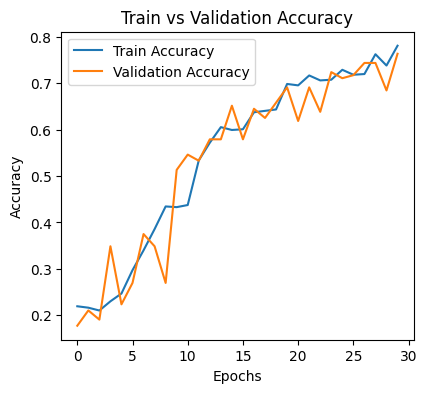

In [3]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot Accuracy 
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

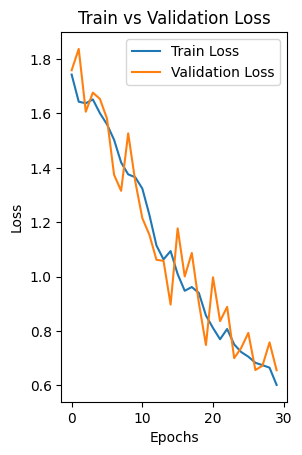

In [4]:
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.show()

In [1]:
model.save('vivit.h5')

NameError: name 'model' is not defined